In [156]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
from statistics import mean, pstdev
from scipy import stats
from scipy.stats import levene, ttest_ind

import numpy as np
import pandas as pd
import xarray as xr
import random
import copy
import statistics as st

In [157]:
time_points = 100
episodes = 40

# parameters ########################

tau = 200# Attenuation rate of internal state in 1 timestep
mouth = 1# Volume of an intake

Alt_IC = [0.3, 0.7, 0.9, 1.1, 1.3, 2.0]# Variety of altered interoception
Alt_beta = [10, 5, 1, 0.5, 0.3, 0.1]# Variety of altered inverse temperature
Alt_gamma = [1.0, 0.99, 0.95, 0.7, 0.4, 0.1]# Variety of altered discounting rate

##################################

sum_D = []
fs = 15# Font size
fig = plt.figure()

<Figure size 640x480 with 0 Axes>

In [158]:
learned_Q = [0,0]# Action-state values are initiated from this values.
learned_K_hat = [0, mouth]# Episodes initiate with learned K^(;oral perception. prediction of increase with an intake.)

In [159]:
class Control:
    def __init__(self, beta=0.6, gamma=0.9, alpha_K_hat=0.3, alpha_Q=0.3, iota=1):
        
        self.N = time_points
        self.a = np.zeros(self.N)# Actions; 0 or 1
        self.D = np.zeros(self.N+1)# Value of drive; D(H)
        self.D_est = np.zeros(self.N+1)# Estimated value of drive
        
        self.H = np.zeros(self.N+1)# Internal state
        self.H[0] = 100# Initial value of the internal state
        self.H_ast = 200# set point of the internal state
        self.P = np.zeros(self.N)# Probability of intake; P(a1)

        self.K = np.zeros(self.N)# Volume of an intake; K
        self.K_hat = np.zeros((2, self.N+1))# Predictive value of increase in H with an action; K^
        self.K_hat[0][0] = learned_K_hat[0]
        self.K_hat[1][0] = learned_K_hat[1]
        
        self.Q = np.zeros((2, self.N+1))# Action-state values
        self.Q[0][0] = learned_Q[0]
        self.Q[1][0] = learned_Q[1]

        self.REin1epi = 0# reward with one intake
        self.total_D = 0# Accumulated drive
        self.total_intake = 0# Accumulated number of intake

        self.R = np.zeros(self.N)# Reward
        self.m = 3# A free parameter of the homeostatic space
        self.n = 4# A free parameter of the homeostatic space

        
        self.alpha_K_hat = alpha_K_hat
        self.alpha_Q = alpha_Q
        self.beta = beta# Inverse temperature
        self.gamma = gamma# Discounting rate
        self.iota = iota# Interoceptive alteration
        self.tau = tau# Attenuation rate of the internal state
        self.mouth = mouth# Volue of an intake
        
        self.D[0] =  ((abs(self.H_ast - self.H[0]))**self.n)**(1/self.m)
        self.D_est[0] = ((self.iota * (abs(self.H_ast - self.H[0])))**self.n)**(1/self.m)
        self.total_D += ((abs(self.H_ast - self.H[0]))**self.n)**(1/self.m)
        
        
    def softmax(self, t):
        self.t = t
        sigma = np.sum(np.exp(self.Q[:, self.t] * self.beta))
        vals = []
        for i in range(2):
            softmax = np.exp(self.Q[i, self.t] * self.beta) / sigma
            vals.append(softmax)
            if i == 1:
                self.P[self.t] = softmax
            
        dice = random.random()
        if dice <= vals[0]:
            self.a[self.t] = 0
        elif vals[0] < dice:
            self.a[self.t] = 1
    
    
    def update_K_hat(self, t):
        self.t = t
        if self.a[self.t] == 0:
            self.K[self.t] = 0
            self.K_hat[0][self.t+1] = self.K_hat[0][self.t]
            self.K_hat[1][self.t+1] = self.K_hat[1][self.t]
        else:
            self.K[self.t] = self.mouth
            self.K_hat[0][self.t+1] = self.K_hat[0][self.t]
            self.K_hat[1][self.t+1] = (1 - self.alpha_K_hat) * self.K_hat[1][self.t] + self.alpha_K_hat * self.mouth
        
        self.total_intake += self.K[self.t]

    
    def get_drive(self, t):
        self.t = t
        if self.a[self.t] == 0:
            self.D_est[self.t+1] = (abs(self.iota *(self.H_ast - (1 - 1/self.tau) * self.H[self.t] - self.K_hat[0][self.t+1]))**self.n)**(1/self.m)
        else:
            self.D_est[self.t+1] = (abs(self.iota *(self.H_ast - (1 - 1/self.tau) * self.H[self.t] - self.K_hat[1][self.t+1]))**self.n)**(1/self.m)

    
    def update_H(self, t):
        self.t = t
        self.H[self.t+1] = (1 - 1/self.tau) * self.H[self.t] + self.K[self.t]


    def update_drive(self, t):
        self.t = t
        self.D[self.t+1] = ((abs(self.H_ast - self.H[self.t+1]))**self.n)**(1/self.m)
        self.total_D += self.D[self.t+1]
        

    def get_reward(self, t):
        self.t = t
        self.R[self.t] = self.D_est[self.t] - self.D_est[self.t+1]
        if self.a[self.t] == 1:
            self.REin1epi += self.R[self.t]
            
            
    def update_Q(self, t):
        self.t = t
        if self.a[self.t] == 0:
            self.Q[0][self.t+1] = self.Q[0][self.t] + self.alpha_Q * (self.R[self.t] + self.gamma * max(self.Q[0][self.t], self.Q[1][self.t]) - self.Q[0][self.t])
            self.Q[1][self.t+1] = self.Q[1][self.t]

        elif self.a[self.t] == 1:
            self.Q[0][self.t+1] = self.Q[0][self.t]
            self.Q[1][self.t+1] = self.Q[1][self.t] + self.alpha_Q * (self.R[self.t] + self.gamma * max(self.Q[0][self.t], self.Q[1][self.t]) - self.Q[1][self.t])


In [160]:
class main():
    def __init__(self, CLASS=Control()):
        self.CLASS = CLASS
        self.time_points = time_points
        self.episodes = episodes
        #self.N_intake = []
        self.g = []
        self.RE = []# Sum of reward only with intake
        self.All_R = []# Sum of reward independent to the behaviours
        self.mouth = mouth
        
        # global intakes
        # intakes = []
        
        self.time_points_l =  list(range(self.time_points + 1))
        self.episodes_l = list(range(self.episodes))

        # Create DataArray
        da = xr.DataArray(np.zeros((self.episodes, 9, self.time_points + 1)), [('Episodes', self.episodes_l), ('variable', ['H', 'Q0', 'Q1', 'P', 'A', 'R', 'K^0', 'K^1', 'D']), ('Time_points', self.time_points_l)])

        self.a_H = np.zeros(self.episodes * (self.time_points + 1))
        self.a_Q0 = np.zeros(self.episodes * (self.time_points + 1))
        self.a_Q1 = np.zeros(self.episodes * (self.time_points + 1))
        self.a_P = np.zeros(self.episodes * (self.time_points + 1))
        self.a_a = np.zeros(self.episodes * (self.time_points + 1))
        self.a_R = np.zeros(self.episodes * (self.time_points + 1))
        self.a_K_h0 = np.zeros(self.episodes * (self.time_points + 1))
        self.a_K_h1 = np.zeros(self.episodes * (self.time_points + 1))
        self.a_D = np.zeros(self.episodes * (self.time_points + 1))


    def execute(self):
        H_main = np.zeros(self.time_points + 1)
        self.y_main = []
        #one_intake_line = []
        for j in range(self.episodes):
            ### 1 episode
            class_l[j] = copy.deepcopy(self.CLASS)
            self.g.append(class_l[j])
            
            for i in range(self.time_points):
                ### 1 timestep
                self.g[-1].softmax(i)
                self.g[-1].update_K_hat(i)
                self.g[-1].get_drive(i)
                self.g[-1].update_H(i)
                self.g[-1].update_drive(i)
                self.g[-1].get_reward(i)
                self.g[-1].update_Q(i)
            
            self.RE.append(self.g[-1].REin1epi)# Reward with intake over 1 Episode
            self.All_R.append(sum(self.g[-1].R))
            
            #one_intake_line.append([])
            #for h in range(self.time_points):
            #    one_intake_line[j].append(sum(self.g[-1].K[:h]))
            
            sum_D.append(self.g[-1].total_D)
            sum_intake.append(self.g[-1].total_intake)

            #intakes.append(one_intake_line[j])
            
            self.main_count = list(self.g[-1].a).count(1)#############名前を要修正
            self.y_main.append(self.main_count)##############名前を要修正
            #self.N_intake.append([])
            #self.N_intake[j].append(np.count_nonzero(self.g[-1].a == 1))

            self.a_H[(self.time_points + 1)*j : (self.time_points + 1)*(j+1)] = class_l[j].H
            self.a_Q0[(self.time_points + 1)*j : (self.time_points + 1)*(j+1)] = class_l[j].Q[0]
            self.a_Q1[(self.time_points + 1)*j : (self.time_points + 1)*(j+1)] = class_l[j].Q[1]
            self.a_a[(self.time_points + 1)*j : (self.time_points + 1)*(j+1)] = np.append(class_l[j].a, np.nan)
            self.a_P[(self.time_points + 1)*j : (self.time_points + 1)*(j+1)] = np.append(class_l[j].P, np.nan)
            self.a_R[(self.time_points + 1)*j : (self.time_points + 1)*(j+1)] = np.append(class_l[j].R, np.nan)
            self.a_K_h0[(self.time_points + 1)*j : (self.time_points + 1)*(j+1)] = class_l[j].K_hat[0]
            self.a_K_h1[(self.time_points + 1)*j : (self.time_points + 1)*(j+1)] = class_l[j].K_hat[1]
            self.a_D[(self.time_points + 1)*j : (self.time_points + 1)*(j+1)] = class_l[j].D
            
        H_main += self.g[-1].H
        
        
        self.df = pd.DataFrame(data=list(range((self.time_points + 1))) * self.episodes, columns=['trial'])
        self.df['H'] = self.a_H
        self.df['Q0'] = self.a_Q0
        self.df['Q1'] = self.a_Q1
        self.df['A'] = self.a_a
        self.df['P'] = self.a_P
        self.df['R'] = self.a_R
        self.df['K^0'] = self.a_K_h0
        self.df['K^1'] = self.a_K_h1
        self.df['D'] = self.a_D


        self.len_l, self.len_s = self.time_points + 1, self.time_points
        x = list(range(self.len_l))
        x2 = list(range(self.len_s))

        fig = plt.figure(figsize=(4, 10))

        self.spec = gridspec.GridSpec(ncols=1, nrows=6, height_ratios=[2,2,1,2,2,2])
#        self.spec = gridspec.GridSpec(ncols=1, nrows=7, height_ratios=[2,2,1,2,2,1,2])
        self.ax_l = []
        self.ax_l.append(fig.add_subplot(self.spec[0]))
        self.ax_l.append(fig.add_subplot(self.spec[1]))
        self.ax_l.append(fig.add_subplot(self.spec[2]))
        self.ax_l.append(fig.add_subplot(self.spec[3]))
        self.ax_l.append(fig.add_subplot(self.spec[4]))
        self.ax_l.append(fig.add_subplot(self.spec[5]))
#        self.ax_l.append(fig.add_subplot(self.spec[6]))
        
        self.CL = 0.95# Confidencial Level for Figures
        self.Df = self.episodes - 1# degree of freedom for Figures

        self.mean = []# mean at t
        self.STD = []
        self.CI = np.zeros((8, self.time_points + 1, 2)) #confidence interval at t

        for j, h in zip(['H','Q0','Q1','P','R','K^0','K^1','D'], list(range(8))):
          for i in range(self.time_points + 1):
              self.mean.append(sum(self.df.loc[self.df['trial']==i][j])/self.episodes)######df が無いので作成＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
              #self.SE.append(stats.sem(self.df.loc[df['trial']==i][j]))
              #self.CI[h][i][0] = stats.t.interval(alpha = self.CL, df = Df, loc = mean[-1], scale = SE[-1])[0]
              #self.CI[h][i][1] = stats.t.interval(alpha = self.CL, df = Df, loc = mean[-1], scale = SE[-1])[1]
              #self.STD.append(st.stdev(self.df.loc[self.df['trial']==i][j]))
              #self.CI[h][i][0] = stats.t.interval(alpha = self.CL, df = self.Df, loc = self.mean[-1], scale = 2*self.STD[-1])[0]
              #self.CI[h][i][1] = stats.t.interval(alpha = self.CL, df = self.Df, loc = self.mean[-1], scale = 2*self.STD[-1])[1]


        # Describe figures
        self.ax_l[0].hlines(230, 0, self.len_l, color='white')
        self.ax_l[0].hlines(200, 0, self.len_l, linestyle="dashed")
        self.ax_l[0].hlines(90, 0, self.len_l, color='white')
        self.ax_l[0].plot(self.g[-1].H[:self.len_l], linewidth=2, color='#00BFFF')
        #self.ax_l[0].fill_between(self.df.index[:self.len_l], self.CI[0, :, 0], self.CI[0, :, 1], color='#00BFFF', alpha=.2) #confidence interval curves.
        self.ax_l[0].set_ylabel('Internal State', fontsize=fs, fontname='Arial')
        self.ax_l[0].tick_params(labelbottom=False)


        for i in range(self.episodes):
            self.conf = self.df['H'][i*(self.len_l):i*(self.len_l)+self.len_l]
            #self.ax_l[0].plot(list(range(self.len_l)), self.conf, linewidth=0.1, color='red')

        self.ax_l[1].hlines(-5, 0, self.len_s, color='white')
        self.ax_l[1].hlines(0, 0, self.len_s, linestyle="dashed")
        self.ax_l[1].hlines(25, 0, self.len_s, color='white')
        self.ax_l[1].plot(self.g[-1].Q[0][:self.len_s], linewidth=2, color='black')
        #self.ax_l[1].fill_between(self.df.index[:self.len_s], self.CI[1, :, 0][:self.len_s], self.CI[1, :, 1][:self.len_s], color='black', alpha=.2)# confidence interval curves.
        self.ax_l[1].plot(self.g[-1].Q[1][:self.len_s], linewidth=2, color='red')
        #self.ax_l[1].fill_between(self.df.index[:self.len_s], self.CI[2, :, 0][:self.len_s], self.CI[2, :, 1][:self.len_s], color='red', alpha=.2)# confidence interval curves.
        self.ax_l[1].set_ylabel('Q-values', fontsize=fs, fontname='Arial')
        self.ax_l[1].tick_params(labelbottom=False)

  
        self.ax_l[2].hlines(0, 0, self.len_s, color="white", alpha=0.01)
        self.ax_l[2].hlines(1, 0, self.len_s, color="white", alpha=0.01)
        self.ax_l[2].scatter(list(range(self.len_s)), self.df['A'][:self.len_s], s=30, c='blue')
        self.ax_l[2].set_ylabel('Actions', fontsize=fs, fontname='Arial')
        self.ax_l[2].tick_params(labelbottom=False)


        self.ax_l[3].hlines(-0.2, 0, self.len_s, color="white")
        self.ax_l[3].hlines(0.5, 0, self.len_s, linestyle="dashed")
        self.ax_l[3].hlines(1.2, 0, self.len_s, color="white")
        self.ax_l[3].hlines(0, 0, self.len_s, linestyle="dashed")
        self.ax_l[3].hlines(1, 0, self.len_s, linestyle="dashed")
        self.ax_l[3].plot(self.df['P'][:self.len_s], linewidth=2, color='red')
        self.ax_l[3].set_ylabel('P(Intake)', fontsize=fs, fontname='Arial')
        #self.ax_l[3].fill_between(self.df.index[:self.len_s], self.CI[3, :, 0][:self.len_s], self.CI[3, :, 1][:self.len_s], color='red', alpha=.2) #confidence interval curves.
        self.ax_l[3].tick_params(labelbottom=False)


        self.ax_l[4].hlines(-15, 0, self.len_s, color="white", alpha=.2)
        self.ax_l[4].hlines(15, 0, self.len_s, color="white", alpha=.2)
        self.ax_l[4].hlines(0, 0, self.len_s, linestyle="dashed")
        self.ax_l[4].plot(self.df['R'][:self.len_s], linewidth=2, color='#00BFFF')
        self.ax_l[4].set_ylabel('Reward', fontsize=fs, fontname='Arial')
        #self.ax_l[4].fill_between(self.df.index[:self.len_s], self.CI[4, :, 0][:self.len_s], self.CI[4, :, 1][:self.len_s], color='#00BFFF', alpha=.2) #confidence interval curves.
        self.ax_l[4].tick_params(labelbottom=False)

        
#        self.ax_l[5].hlines(0, 0, self.len_l, linestyle="dashed")
#        self.ax_l[5].hlines(self.mouth, 0, self.len_l, linestyle="dashed")
#        self.ax_l[5].plot(self.g[-1].K_hat[0], linewidth=2, color='black')
#        self.ax_l[5].fill_between(self.df.index[:self.len_l], self.CI[5, :, 0][:self.len_l], self.CI[5, :, 1][:self.len_l], color='black', alpha=.2) #confidence interval curves.        
#        self.ax_l[5].plot(self.g[-1].K_hat[1], linewidth=2, color='red')
#        self.ax_l[5].fill_between(self.df.index[:self.len_l], self.CI[6, :, 0][:self.len_l], self.CI[6, :, 1][:self.len_l], color='red', alpha=.2) #confidence interval curves.
#        self.ax_l[5].set_ylabel('K^', fontsize=fs, fontname='Arial')
#        self.ax_l[5].tick_params(labelbottom=False)

        
        self.ax_l[5].hlines(600, 0, self.len_l, color='white')
        self.ax_l[5].hlines(0, 0, self.len_l, linestyle="dashed")
        self.ax_l[5].plot(self.g[-1].D, linewidth=2, color='#00BFFF')
        #self.ax_l[5].fill_between(self.df.index[:self.len_l], self.CI[7, :, 0][:self.len_l], self.CI[7, :, 1][:self.len_l], color='#00BFFF', alpha=.2) #confidence interval curves.
        self.ax_l[5].set_ylabel('Drive', fontsize=fs, fontname='Arial')
        #self.ax_l[5].tick_params(labelbottom=False)
        

In [161]:
global loss_l
loss_l = []

global class_l
class_l = []

global sum_D
sum_D = []

global sum_RE#Only intake behaviours
sum_RE = []

global sum_intake
sum_intake = []

for i in range(episodes):
    class_l.append(0)

Reward in 1 episode: 226.02583091203633
Intake list: 98.375
Sum of D: 34927.14917057625


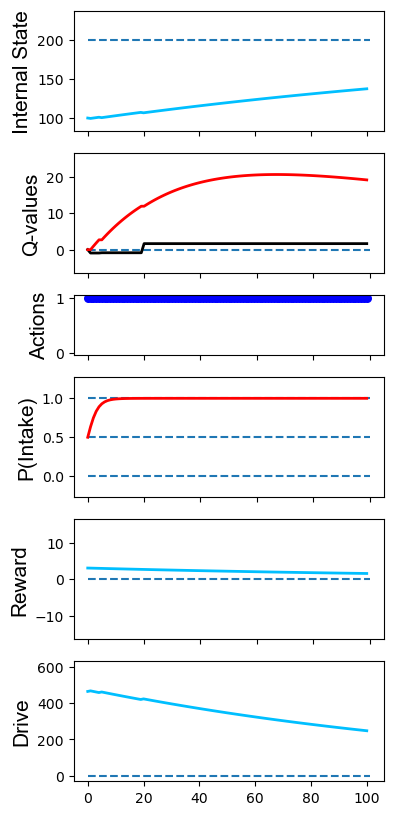

In [162]:
control = main()
control.execute()

print("Reward in 1 episode: " + str(sum(control.RE)/episodes))
print("Intake list: " + str(sum(sum_intake)/episodes))
print("Sum of D: " + str(sum(sum_D)/episodes))

Control_sum_intake = np.array(sum_intake)
Control_sum_D = np.array(sum_D)
Control_sum_RE = np.array(control.RE)
Control_all_R = np.array(control.All_R)

sum_intake = []
sum_D = []

Reward in 1 episode: 38.55362995884356
Intake list: 69.525
Sum of D: 41991.10524542267


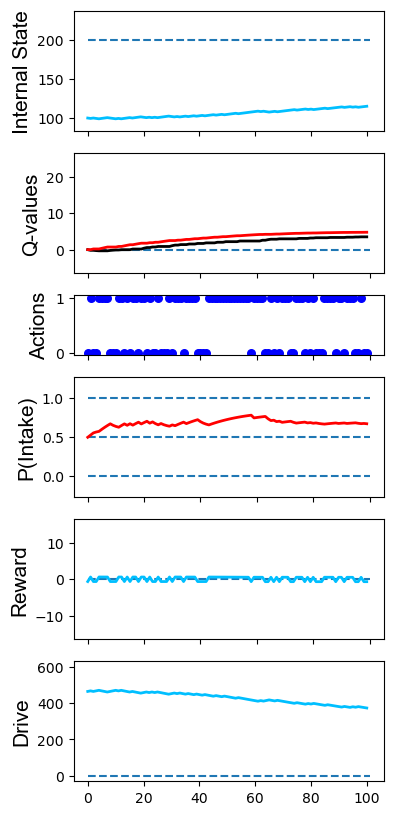

In [163]:
# IC 03
IC03 = main(CLASS=Control(iota=Alt_IC[0]))
IC03.execute()

print("Reward in 1 episode: " + str(sum(IC03.RE)/episodes))
print("Intake list: " + str(sum(sum_intake)/episodes))
print("Sum of D: " + str(sum(sum_D)/episodes))

IC03_sum_intake = np.array(sum_intake)
IC03_sum_D = np.array(sum_D)
IC03_sum_RE = np.array(IC03.RE)
IC03_all_R = np.array(IC03.All_R)

sum_intake = []
sum_D = []

Reward in 1 episode: 140.3235201719203
Intake list: 97.275
Sum of D: 35384.031452043484


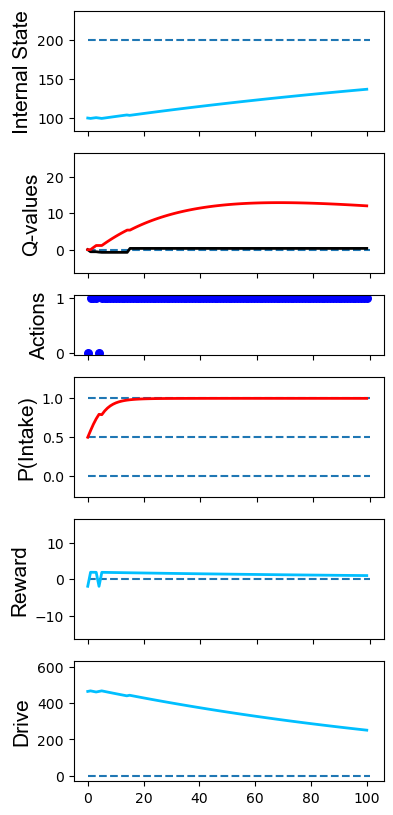

In [164]:
# IC 07
IC07 = main(CLASS=Control(iota=Alt_IC[1]))
IC07.execute()

print("Reward in 1 episode: " + str(sum(IC07.RE)/episodes))
print("Intake list: " + str(sum(sum_intake)/episodes))
print("Sum of D: " + str(sum(sum_D)/episodes))

IC07_sum_intake = np.array(sum_intake)
IC07_sum_D = np.array(sum_D)
IC07_sum_RE = np.array(IC07.RE)
IC07_all_R = np.array(IC07.All_R)

sum_intake = []
sum_D = []

Reward in 1 episode: 196.3380254155577
Intake list: 97.9
Sum of D: 35135.93879343036


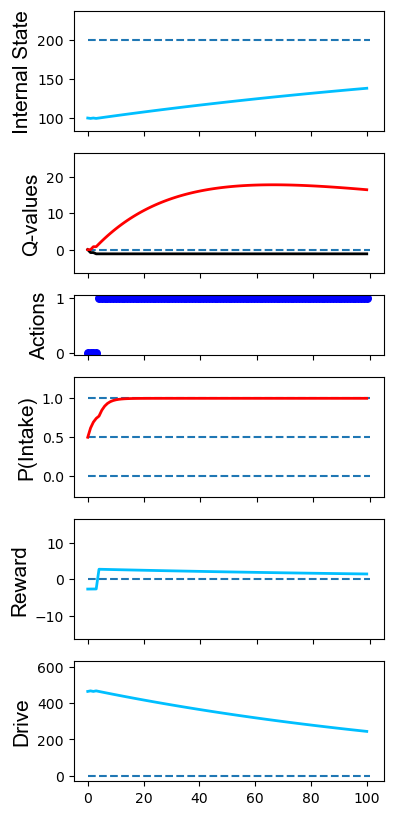

In [165]:
# IC 09
IC09 = main(CLASS=Control(iota=Alt_IC[2]))
IC09.execute()

print("Reward in 1 episode: " + str(sum(IC09.RE)/episodes))
print("Intake list: " + str(sum(sum_intake)/episodes))
print("Sum of D: " + str(sum(sum_D)/episodes))

IC09_sum_intake = np.array(sum_intake)
IC09_sum_D = np.array(sum_D)
IC09_sum_RE = np.array(IC09.RE)
IC09_all_R = np.array(IC09.All_R)

sum_intake = []
sum_D = []

Reward in 1 episode: 256.7116009310102
Intake list: 98.6
Sum of D: 34829.59973387244


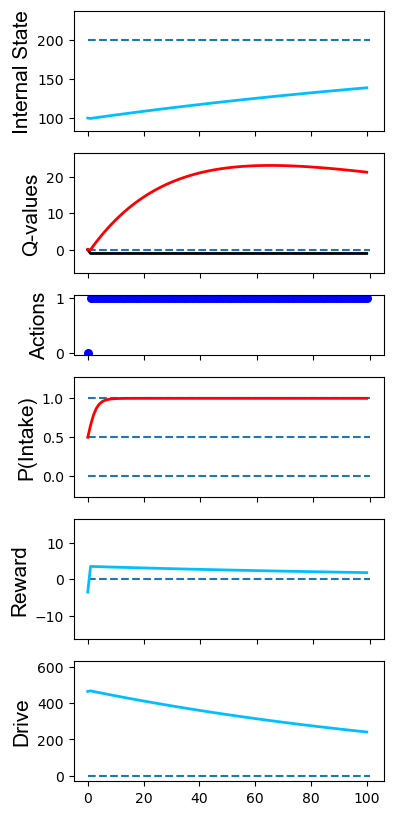

In [166]:
# IC 11
IC11 = main(CLASS=Control(iota=Alt_IC[3]))
IC11.execute()

print("Reward in 1 episode: " + str(sum(IC11.RE)/episodes))
print("Intake list: " + str(sum(sum_intake)/episodes))
print("Sum of D: " + str(sum(sum_D)/episodes))

IC11_sum_intake = np.array(sum_intake)
IC11_sum_D = np.array(sum_D)
IC11_sum_RE = np.array(IC11.RE)
IC11_all_R = np.array(IC11.All_R)

sum_intake = []
sum_D = []

Reward in 1 episode: 320.81288360592555
Intake list: 98.825
Sum of D: 34731.867899707526


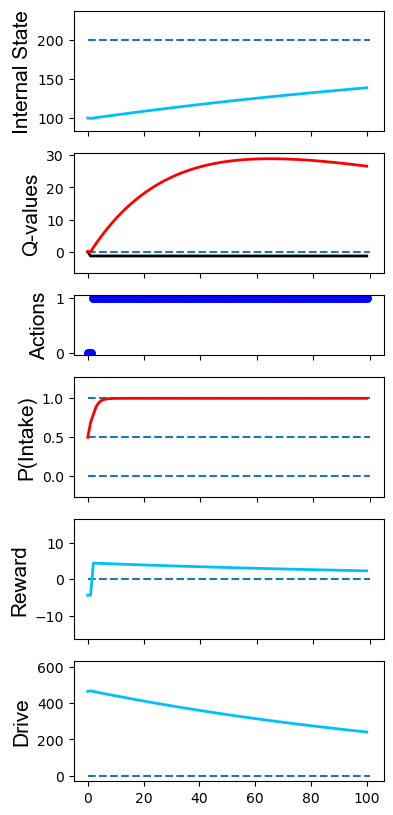

In [167]:
# IC 13
IC13 = main(CLASS=Control(iota=Alt_IC[4]))
IC13.execute()

print("Reward in 1 episode: " + str(sum(IC13.RE)/episodes))
print("Intake list: " + str(sum(sum_intake)/episodes))
print("Sum of D: " + str(sum(sum_D)/episodes))

IC13_sum_intake = np.array(sum_intake)
IC13_sum_D = np.array(sum_D)
IC13_sum_RE = np.array(IC13.RE)
IC13_all_R = np.array(IC13.All_R)

sum_intake = []
sum_D = []

Reward in 1 episode: 569.8822503744907
Intake list: 99.125
Sum of D: 34598.78667220043


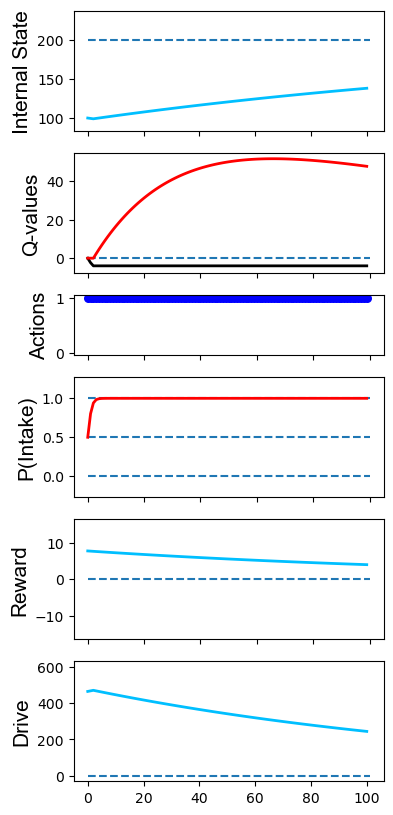

In [168]:
# IC 20
IC20 = main(CLASS=Control(iota=Alt_IC[5]))
IC20.execute()

print("Reward in 1 episode: " + str(sum(IC20.RE)/episodes))
print("Intake list: " + str(sum(sum_intake)/episodes))
print("Sum of D: " + str(sum(sum_D)/episodes))

IC20_sum_intake = np.array(sum_intake)
IC20_sum_D = np.array(sum_D)
IC20_sum_RE = np.array(IC20.RE)
IC20_all_R = np.array(IC20.All_R)

sum_intake = []
sum_D = []

Reward in 1 episode: 226.20173140498414
Intake list: 99.5
Sum of D: 34430.17512242093


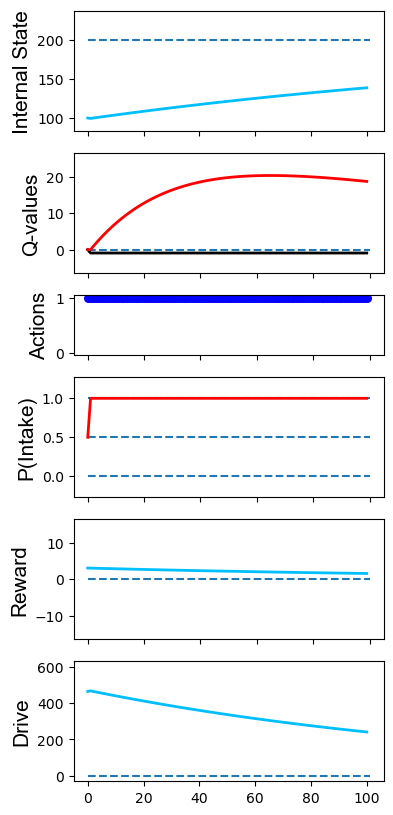

In [169]:
# beta 10
beta10 = main(CLASS=Control(beta=Alt_beta[0]))
beta10.execute()

print("Reward in 1 episode: " + str(sum(beta10.RE)/episodes))
print("Intake list: " + str(sum(sum_intake)/episodes))
print("Sum of D: " + str(sum(sum_D)/episodes))

beta10_sum_intake = np.array(sum_intake)
beta10_sum_D = np.array(sum_D)
beta10_sum_RE = np.array(beta10.RE)
beta10_all_R = np.array(beta10.All_R)

sum_intake = []
sum_D = []

Reward in 1 episode: 226.1920894622984
Intake list: 99.4
Sum of D: 34475.46285054034


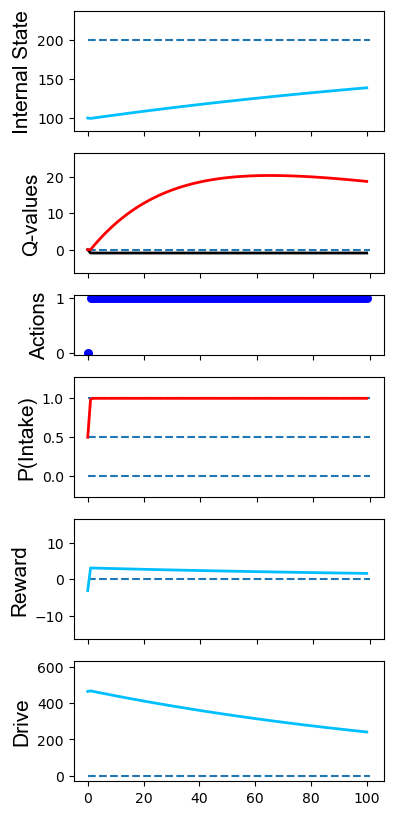

In [170]:
# beta 5
beta5 = main(CLASS=Control(beta=Alt_beta[1]))
beta5.execute()

print("Reward in 1 episode: " + str(sum(beta5.RE)/episodes))
print("Intake list: " + str(sum(sum_intake)/episodes))
print("Sum of D: " + str(sum(sum_D)/episodes))

beta5_sum_intake = np.array(sum_intake)
beta5_sum_D = np.array(sum_D)
beta5_sum_RE = np.array(beta5.RE)
beta5_all_R = np.array(beta5.All_R)

sum_intake = []
sum_D = []

Reward in 1 episode: 226.09003361768447
Intake list: 98.7
Sum of D: 34787.334715072044


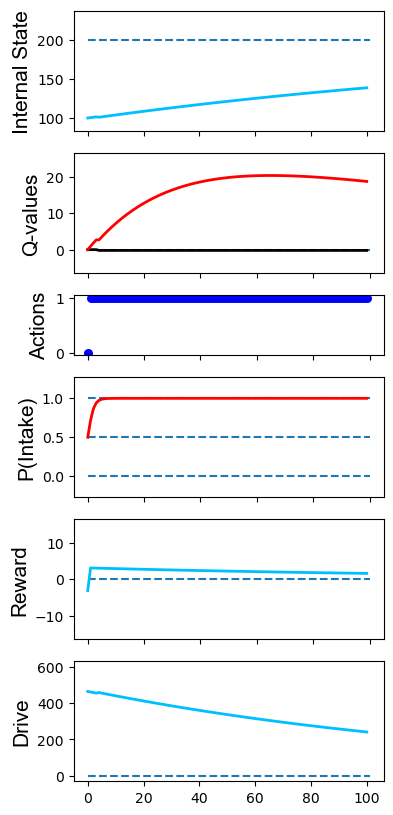

In [171]:
# beta 1
beta1 = main(CLASS=Control(beta=Alt_beta[2]))
beta1.execute()

print("Reward in 1 episode: " + str(sum(beta1.RE)/episodes))
print("Intake list: " + str(sum(sum_intake)/episodes))
print("Sum of D: " + str(sum(sum_D)/episodes))

beta1_sum_intake = np.array(sum_intake)
beta1_sum_D = np.array(sum_D)
beta1_sum_RE = np.array(beta1.RE)
beta1_all_R = np.array(beta1.All_R)

sum_intake = []
sum_D = []

Reward in 1 episode: 225.95411072523484
Intake list: 97.95
Sum of D: 35105.842848418644


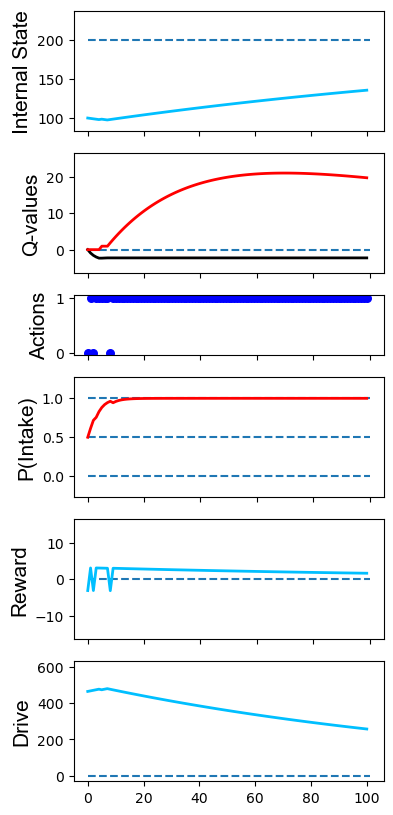

In [172]:
# beta 05
beta05 = main(CLASS=Control(beta=Alt_beta[3]))
beta05.execute()

print("Reward in 1 episode: " + str(sum(beta05.RE)/episodes))
print("Intake list: " + str(sum(sum_intake)/episodes))
print("Sum of D: " + str(sum(sum_D)/episodes))

beta05_sum_intake = np.array(sum_intake)
beta05_sum_D = np.array(sum_D)
beta05_sum_RE = np.array(beta05.RE)
beta05_all_R = np.array(beta05.All_R)

sum_intake = []
sum_D = []

Reward in 1 episode: 225.15714707797014
Intake list: 96.125
Sum of D: 35766.168915820504


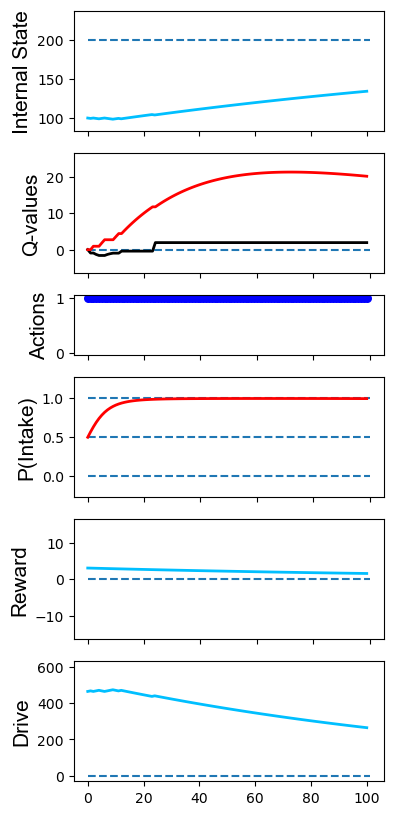

In [173]:
# beta 03
beta03 = main(CLASS=Control(beta=Alt_beta[4]))
beta03.execute()

print("Reward in 1 episode: " + str(sum(beta03.RE)/episodes))
print("Intake list: " + str(sum(sum_intake)/episodes))
print("Sum of D: " + str(sum(sum_D)/episodes))

beta03_sum_intake = np.array(sum_intake)
beta03_sum_D = np.array(sum_D)
beta03_sum_RE = np.array(beta03.RE)
beta03_all_R = np.array(beta03.All_R)

sum_intake = []
sum_D = []

Reward in 1 episode: 186.3030744962773
Intake list: 65.825
Sum of D: 42955.468531410486


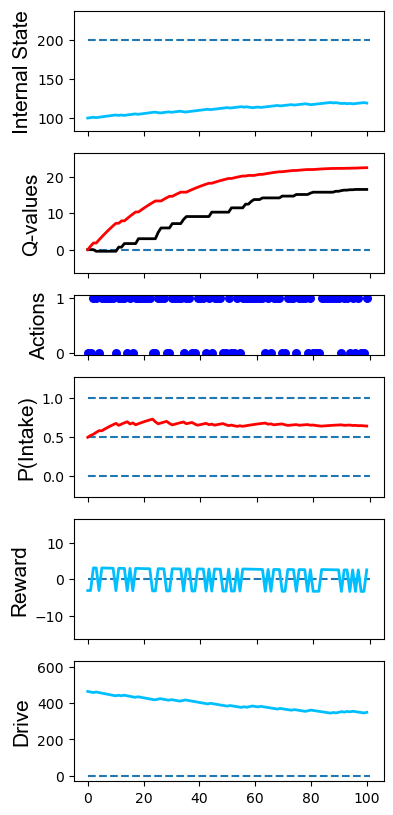

In [174]:
# beta 01
beta01 = main(CLASS=Control(beta=Alt_beta[5]))
beta01.execute()

print("Reward in 1 episode: " + str(sum(beta01.RE)/episodes))
print("Intake list: " + str(sum(sum_intake)/episodes))
print("Sum of D: " + str(sum(sum_D)/episodes))

beta01_sum_intake = np.array(sum_intake)
beta01_sum_D = np.array(sum_D)
beta01_sum_RE = np.array(beta01.RE)
beta01_all_R = np.array(beta01.All_R)

sum_intake = []
sum_D = []

Reward in 1 episode: 225.9958356192592
Intake list: 98.1
Sum of D: 35052.26061929217


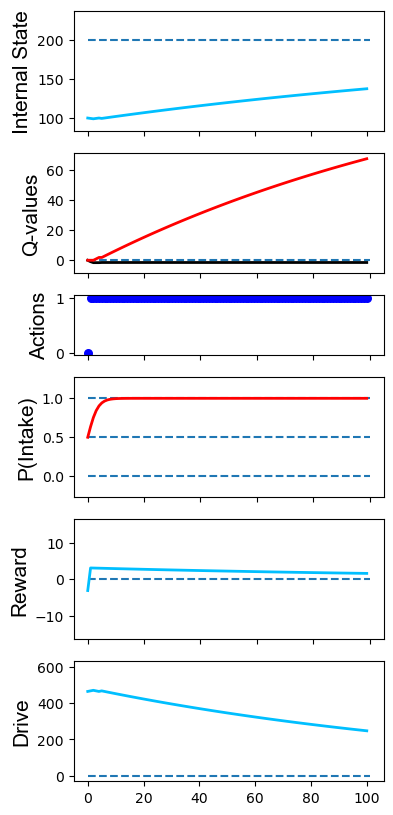

In [175]:
# gamma 10
gamma10 = main(CLASS=Control(gamma=Alt_gamma[0]))
gamma10.execute()

print("Reward in 1 episode: " + str(sum(gamma10.RE)/episodes))
print("Intake list: " + str(sum(sum_intake)/episodes))
print("Sum of D: " + str(sum(sum_D)/episodes))

gamma10_sum_intake = np.array(sum_intake)
gamma10_sum_D = np.array(sum_D)
gamma10_sum_RE = np.array(gamma10.RE)
gamma10_all_R = np.array(gamma10.All_R)

sum_intake = []
sum_D = []

Reward in 1 episode: 225.9827533894989
Intake list: 98.025
Sum of D: 35086.26176583064


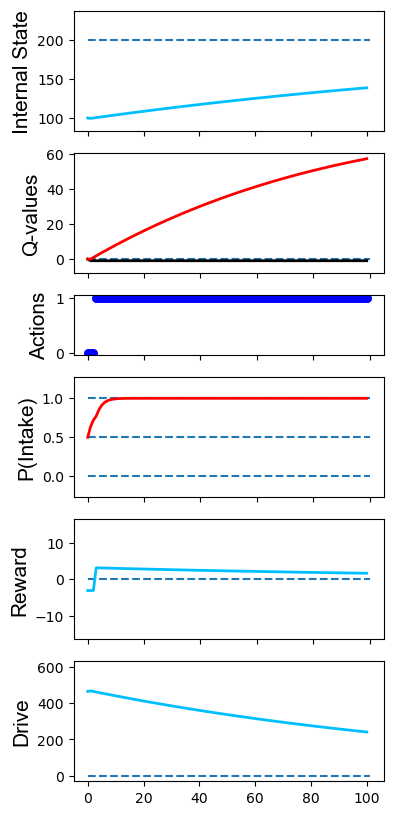

In [176]:
# gamma 099
gamma099 = main(CLASS=Control(gamma=Alt_gamma[1]))
gamma099.execute()

print("Reward in 1 episode: " + str(sum(gamma099.RE)/episodes))
print("Intake list: " + str(sum(sum_intake)/episodes))
print("Sum of D: " + str(sum(sum_D)/episodes))

gamma099_sum_intake = np.array(sum_intake)
gamma099_sum_D = np.array(sum_D)
gamma099_sum_RE = np.array(gamma099.RE)
gamma099_all_R = np.array(gamma099.All_R)

sum_intake = []
sum_D = []

Reward in 1 episode: 226.0794919251536
Intake list: 98.675
Sum of D: 34794.72686793858


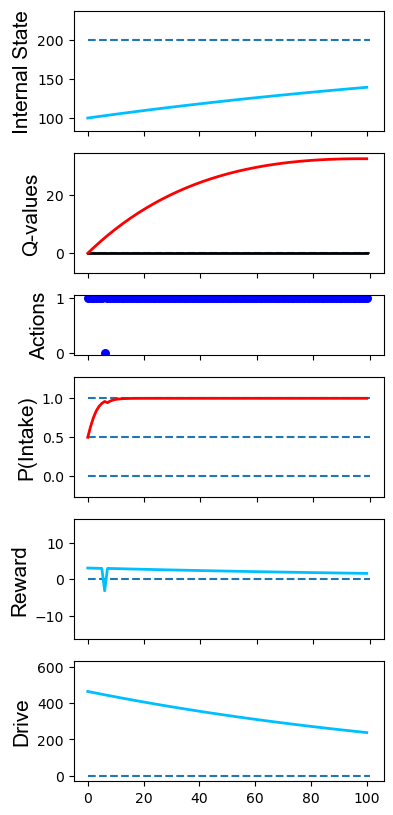

In [177]:
# gamma 095
gamma095 = main(CLASS=Control(gamma=Alt_gamma[2]))
gamma095.execute()

print("Reward in 1 episode: " + str(sum(gamma095.RE)/episodes))
print("Intake list: " + str(sum(sum_intake)/episodes))
print("Sum of D: " + str(sum(sum_D)/episodes))

gamma095_sum_intake = np.array(sum_intake)
gamma095_sum_D = np.array(sum_D)
gamma095_sum_RE = np.array(gamma095.RE)
gamma095_all_R = np.array(gamma095.All_R)

sum_intake = []
sum_D = []

Reward in 1 episode: 225.38510532813453
Intake list: 97.875
Sum of D: 34957.69790280496


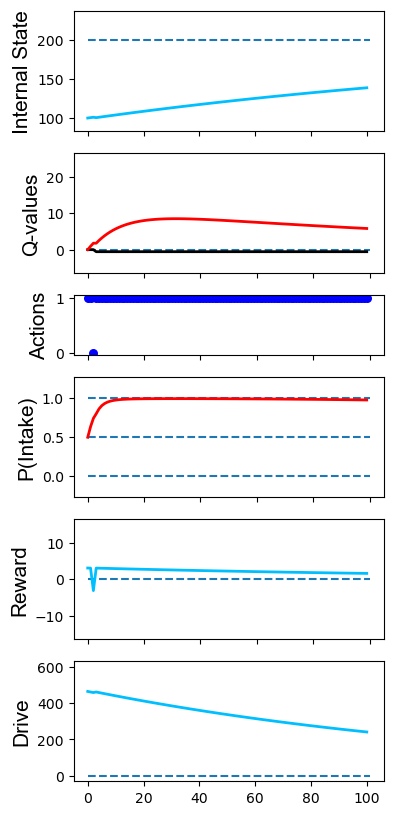

In [178]:
# gamma 07
gamma07 = main(CLASS=Control(gamma=Alt_gamma[3]))
gamma07.execute()

print("Reward in 1 episode: " + str(sum(gamma07.RE)/episodes))
print("Intake list: " + str(sum(sum_intake)/episodes))
print("Sum of D: " + str(sum(sum_D)/episodes))

gamma07_sum_intake = np.array(sum_intake)
gamma07_sum_D = np.array(sum_D)
gamma07_sum_RE = np.array(gamma07.RE)
gamma07_all_R = np.array(gamma07.All_R)

sum_intake = []
sum_D = []

Reward in 1 episode: 222.2144942326769
Intake list: 94.025
Sum of D: 35863.049211232064


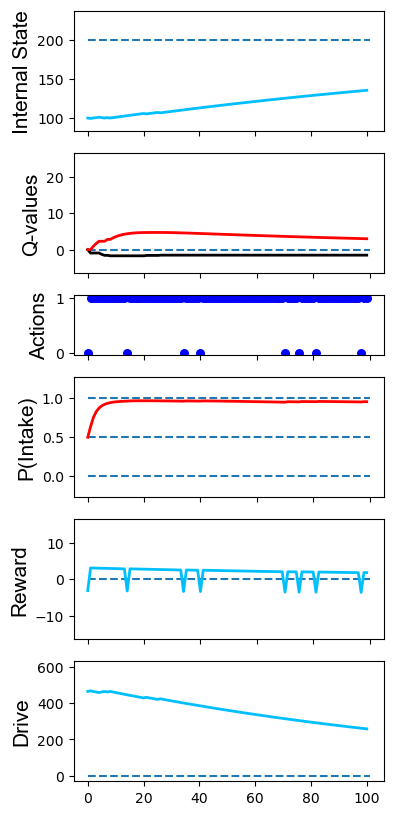

In [179]:
# gamma 04
gamma04 = main(CLASS=Control(gamma=Alt_gamma[4]))
gamma04.execute()

print("Reward in 1 episode: " + str(sum(gamma04.RE)/episodes))
print("Intake list: " + str(sum(sum_intake)/episodes))
print("Sum of D: " + str(sum(sum_D)/episodes))

gamma04_sum_intake = np.array(sum_intake)
gamma04_sum_D = np.array(sum_D)
gamma04_sum_RE = np.array(gamma04.RE)
gamma04_all_R = np.array(gamma04.All_R)

sum_intake = []
sum_D = []

Reward in 1 episode: 222.11442053752117
Intake list: 93.475
Sum of D: 36099.097231964384


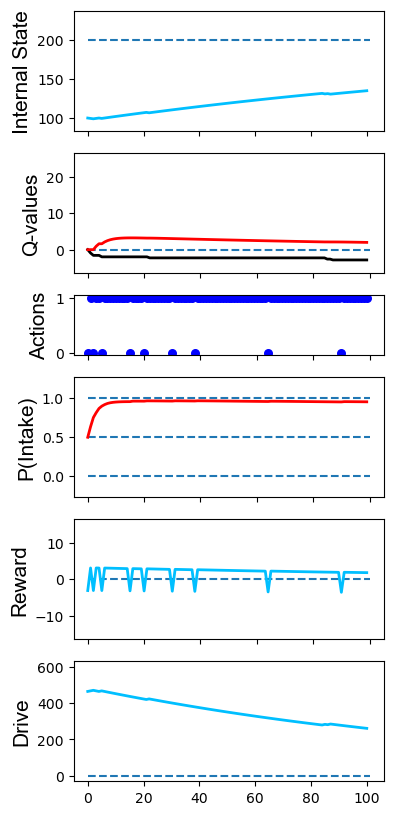

In [180]:
# gamma 01
gamma01 = main(CLASS=Control(gamma=Alt_gamma[5]))
gamma01.execute()

print("Reward in 1 episode: " + str(sum(gamma01.RE)/episodes))
print("Intake list: " + str(sum(sum_intake)/episodes))
print("Sum of D: " + str(sum(sum_D)/episodes))

gamma01_sum_intake = np.array(sum_intake)
gamma01_sum_D = np.array(sum_D)
gamma01_sum_RE = np.array(gamma01.RE)
gamma01_all_R = np.array(gamma01.All_R)

sum_intake = []
sum_D = []

In [181]:
loss_l = []
r_l = []
# mean and SD of intake volumes
left = np.array(list(range(7)))

ers0_mu = np.mean(np.array(IC03_sum_intake))
ers1_mu = np.mean(np.array(IC07_sum_intake))
ers2_mu = np.mean(np.array(IC09_sum_intake))

ers3_mu = np.mean(np.array(Control_sum_intake))

ers4_mu = np.mean(np.array(IC11_sum_intake))
ers5_mu = np.mean(np.array(IC13_sum_intake))
ers6_mu = np.mean(np.array(IC20_sum_intake))


# altered beta
ers7_mu = np.mean(np.array(beta10_sum_intake))
ers8_mu = np.mean(np.array(beta5_sum_intake))
ers9_mu = np.mean(np.array(beta1_sum_intake))

ers10_mu = np.mean(np.array(Control_sum_intake))

ers11_mu = np.mean(np.array(beta05_sum_intake))
ers12_mu = np.mean(np.array(beta03_sum_intake))
ers13_mu = np.mean(np.array(beta01_sum_intake))


# alteres gamma
ers14_mu = np.mean(np.array(gamma10_sum_intake))
ers15_mu = np.mean(np.array(gamma099_sum_intake))
ers16_mu = np.mean(np.array(gamma095_sum_intake))

ers17_mu = np.mean(np.array(Control_sum_intake))

ers18_mu = np.mean(np.array(gamma07_sum_intake))
ers19_mu = np.mean(np.array(gamma04_sum_intake))
ers20_mu = np.mean(np.array(gamma01_sum_intake))
sum_D = []

In [182]:
# total volume of intake
intake_lists_IC = [[], [], [], [], [], [], []]


for i in IC03_sum_intake:
  intake_lists_IC[0].append(i)
for i in IC07_sum_intake:
  intake_lists_IC[1].append(i)
for i in IC09_sum_intake:
  intake_lists_IC[2].append(i)

for i in Control_sum_intake:
  intake_lists_IC[3].append(i)

for i in IC11_sum_intake:
  intake_lists_IC[4].append(i)
for i in IC13_sum_intake:
  intake_lists_IC[5].append(i)
for i in IC20_sum_intake:
  intake_lists_IC[6].append(i)



intake_lists_beta = [[], [], [], [], [], [], []]


for i in beta10_sum_intake:
  intake_lists_beta[0].append(i)
for i in beta5_sum_intake:
  intake_lists_beta[1].append(i)
for i in beta1_sum_intake:
  intake_lists_beta[2].append(i)

for i in Control_sum_intake:
  intake_lists_beta[3].append(i)

for i in beta05_sum_intake:
  intake_lists_beta[4].append(i)
for i in beta03_sum_intake:
  intake_lists_beta[5].append(i)
for i in beta01_sum_intake:
  intake_lists_beta[6].append(i)



intake_lists_gamma = [[], [], [], [], [], [], []]


for i in gamma10_sum_intake:
  intake_lists_gamma[0].append(i)
for i in gamma099_sum_intake:
  intake_lists_gamma[1].append(i)
for i in gamma095_sum_intake:
  intake_lists_gamma[2].append(i)

for i in Control_sum_intake:
  intake_lists_gamma[3].append(i)

for i in gamma07_sum_intake:
  intake_lists_gamma[4].append(i)
for i in gamma04_sum_intake:
  intake_lists_gamma[5].append(i)
for i in gamma01_sum_intake:
  intake_lists_gamma[6].append(i)


In [183]:
# mean of intake volumes
left = np.array(list(range(7)))

ers0_mu = mean(intake_lists_IC[0])
ers1_mu = mean(intake_lists_IC[1])
ers2_mu = mean(intake_lists_IC[2])

ers3_mu = mean(intake_lists_IC[3])

ers4_mu = mean(intake_lists_IC[4])
ers5_mu = mean(intake_lists_IC[5])
ers6_mu = mean(intake_lists_IC[6])


# altered beta
ers7_mu = mean(intake_lists_beta[0])
ers8_mu = mean(intake_lists_beta[1])
ers9_mu = mean(intake_lists_beta[2])

ers10_mu = mean(intake_lists_beta[3])

ers11_mu = mean(intake_lists_beta[4])
ers12_mu = mean(intake_lists_beta[5])
ers13_mu = mean(intake_lists_beta[6])


# alteres gamma
ers14_mu = mean(intake_lists_gamma[0])
ers15_mu = mean(intake_lists_gamma[1])
ers16_mu = mean(intake_lists_gamma[2])

ers17_mu = mean(intake_lists_gamma[3])

ers18_mu = mean(intake_lists_gamma[4])
ers19_mu = mean(intake_lists_gamma[5])
ers20_mu = mean(intake_lists_gamma[6])

In [184]:
# SD of intake volumes
left = np.array(list(range(7)))

ers0_sd = pstdev(intake_lists_IC[0])
ers1_sd = pstdev(intake_lists_IC[1])
ers2_sd = pstdev(intake_lists_IC[2])

ers3_sd = pstdev(intake_lists_IC[3])

ers4_sd = pstdev(intake_lists_IC[4])
ers5_sd = pstdev(intake_lists_IC[5])
ers6_sd = pstdev(intake_lists_IC[6])


# altered beta
ers7_sd = pstdev(intake_lists_beta[0])
ers8_sd = pstdev(intake_lists_beta[1])
ers9_sd = pstdev(intake_lists_beta[2])

ers10_sd = pstdev(intake_lists_beta[3])

ers11_sd = pstdev(intake_lists_beta[4])
ers12_sd = pstdev(intake_lists_beta[5])
ers13_sd = pstdev(intake_lists_beta[6])


# alteres gamma
ers14_sd = pstdev(intake_lists_gamma[0])
ers15_sd = pstdev(intake_lists_gamma[1])
ers16_sd = pstdev(intake_lists_gamma[2])

ers17_sd = pstdev(intake_lists_gamma[3])

ers18_sd = pstdev(intake_lists_gamma[4])
ers19_sd = pstdev(intake_lists_gamma[5])
ers20_sd = pstdev(intake_lists_gamma[6])

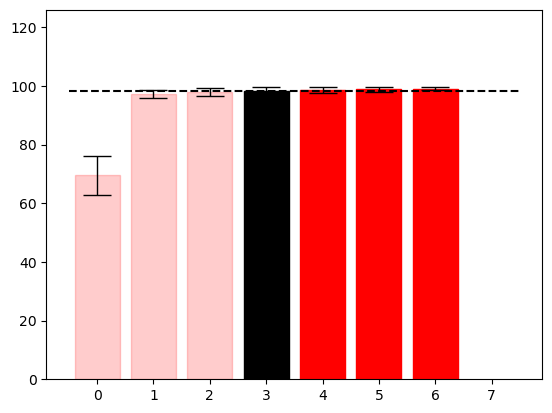

Sum of intake, altered interoception


In [185]:
# Total intake, altered IC
y_intake_IC = np.array([ers0_mu, ers1_mu, ers2_mu, ers3_mu, ers4_mu, ers5_mu, ers6_mu])
e_intake_IC = np.array([ers0_sd, ers1_sd, ers2_sd, ers3_sd, ers4_sd, ers5_sd, ers6_sd])

error_bar_set = dict(lw = 1, capthick = 1, capsize = 10)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
bar_intake_IC = ax.bar(left, y_intake_IC, yerr = e_intake_IC, error_kw=error_bar_set)
ax.hlines(ers3_mu, -0.5, len(left)+0.5, linestyle="dashed", color="k")# control

for i in range(7):
  if i != 3:
    bar_intake_IC[i].set_color('red')
  else:
    bar_intake_IC[i].set_color('black')

for i in range(3):
  bar_intake_IC[i].set_alpha(0.2)

for i in range(3):
  bar_intake_IC[i+4].set_alpha(1)

ax.hlines(120, 0, len(left), color='white')
plt.show()
print("Sum of intake, altered interoception")

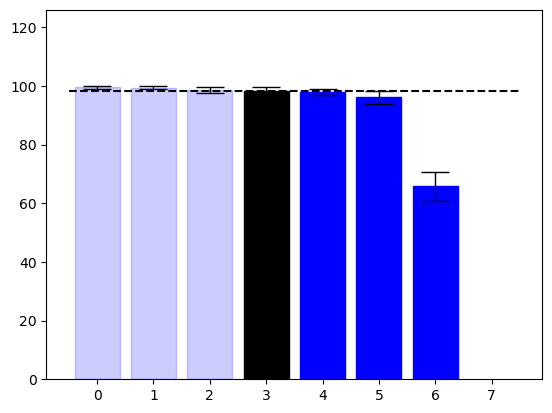

Sum of intake, altered beta


In [186]:
# Total intake, altered beta
y_intake_beta = np.array([ers7_mu, ers8_mu, ers9_mu, ers10_mu, ers11_mu, ers12_mu, ers13_mu])
e_intake_beta = np.array([ers7_sd, ers8_sd, ers9_sd, ers10_sd, ers11_sd, ers12_sd, ers13_sd])

error_bar_set = dict(lw = 1, capthick = 1, capsize = 10)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
bar_intake_beta = ax.bar(left, y_intake_beta, yerr = e_intake_beta, error_kw=error_bar_set)
ax.hlines(ers10_mu, -0.5, len(left)+0.5, linestyle="dashed", color="k")# control

for i in range(7):
  if i != 3:
    bar_intake_beta[i].set_color('blue')
  else:
    bar_intake_beta[i].set_color('black')

for i in range(3):
  bar_intake_beta[i].set_alpha(0.2)

ax.hlines(120, 0, len(left), color='white')

for i in range(3):
  bar_intake_beta[i+4].set_alpha(1)
plt.show()
print("Sum of intake, altered beta")


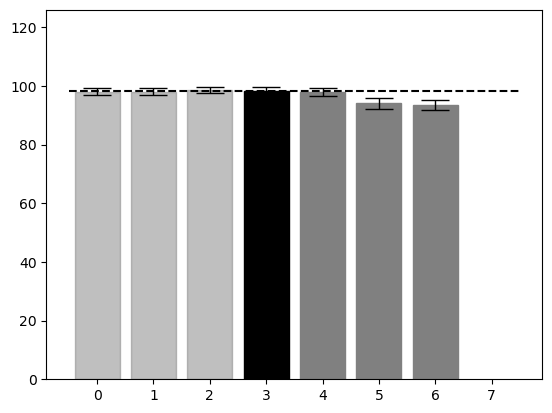

Sum of intake, altered gamma


In [187]:
# Total intake, altered gamma
y_intake_gamma = np.array([ers14_mu, ers15_mu, ers16_mu, ers17_mu, ers18_mu, ers19_mu, ers20_mu])
e_intake_gamma = np.array([ers14_sd, ers15_sd, ers16_sd, ers17_sd, ers18_sd, ers19_sd, ers20_sd])

error_bar_set = dict(lw = 1, capthick = 1, capsize = 10)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
bar_intake_gamma = ax.bar(left, y_intake_gamma, yerr = e_intake_gamma, error_kw=error_bar_set)
ax.hlines(ers17_mu, -0.5, len(left)+0.5, linestyle="dashed", color="k")# control

for i in range(7):
  if i != 3:
    bar_intake_gamma[i].set_color('gray')
  else:
    bar_intake_gamma[i].set_color('black')

for i in range(3):
  bar_intake_gamma[i].set_alpha(0.5)

for i in range(3):
  bar_intake_gamma[i+4].set_alpha(1)

ax.hlines(120, 0, len(left), color='white')
plt.show()
print("Sum of intake, altered gamma")

In [188]:
# Figure: Sum of reward in 1 episode

Divided_Rewards = []

# sum(np.array/np.array) の形にする
Divided_Rewards.append(mean(IC03_sum_RE/IC03_sum_intake))
Divided_Rewards.append(mean(IC07_sum_RE/IC07_sum_intake))
Divided_Rewards.append(mean(IC09_sum_RE/IC09_sum_intake))

Divided_Rewards.append(mean(Control_sum_RE/Control_sum_intake))

Divided_Rewards.append(mean(IC11_sum_RE/IC11_sum_intake))
Divided_Rewards.append(mean(IC13_sum_RE/IC13_sum_intake))
Divided_Rewards.append(mean(IC20_sum_RE/IC20_sum_intake))



Divided_Rewards.append(mean(beta10_sum_RE/beta10_sum_intake))
Divided_Rewards.append(mean(beta5_sum_RE/beta5_sum_intake))
Divided_Rewards.append(mean(beta1_sum_RE/beta1_sum_intake))

Divided_Rewards.append(mean(Control_sum_RE.mean()/Control_sum_intake))

Divided_Rewards.append(mean(beta05_sum_RE/beta05_sum_intake))
Divided_Rewards.append(mean(beta03_sum_RE/beta03_sum_intake))
Divided_Rewards.append(mean(beta01_sum_RE/beta01_sum_intake))



Divided_Rewards.append(mean(gamma10_sum_RE/gamma10_sum_intake))
Divided_Rewards.append(mean(gamma099_sum_RE/gamma099_sum_intake))
Divided_Rewards.append(mean(gamma095_sum_RE/gamma095_sum_intake))

Divided_Rewards.append(mean(Control_sum_RE.mean()/Control_sum_intake))

Divided_Rewards.append(mean(gamma07_sum_RE/gamma07_sum_intake))
Divided_Rewards.append(mean(gamma04_sum_RE/gamma04_sum_intake))
Divided_Rewards.append(mean(gamma01_sum_RE/gamma01_sum_intake))



Divided_Rewards_array_IC = [IC03_sum_RE, IC07_sum_RE, IC09_sum_RE, Control_sum_RE, IC11_sum_RE, IC13_sum_RE, IC20_sum_RE]
Divided_Rewards_array_beta = [beta10_sum_RE, beta5_sum_RE, beta1_sum_RE, Control_sum_RE, beta05_sum_RE, beta03_sum_RE, beta01_sum_RE]
Divided_Rewards_array_gamma = [gamma10_sum_RE, gamma099_sum_RE, gamma095_sum_RE, Control_sum_RE, gamma07_sum_RE, gamma04_sum_RE, gamma01_sum_RE]



Divided_Rewards_sd = []

Divided_Rewards_sd.append(np.std(IC03_sum_RE/IC03_sum_intake))
Divided_Rewards_sd.append(np.std(IC07_sum_RE/IC07_sum_intake))
Divided_Rewards_sd.append(np.std(IC09_sum_RE/IC09_sum_intake))

Divided_Rewards_sd.append(np.std(Control_sum_RE/Control_sum_intake))

Divided_Rewards_sd.append(np.std(IC11_sum_RE/IC11_sum_intake))
Divided_Rewards_sd.append(np.std(IC13_sum_RE/IC13_sum_intake))
Divided_Rewards_sd.append(np.std(IC20_sum_RE/IC20_sum_intake))



Divided_Rewards_sd.append(np.std(beta10_sum_RE/beta10_sum_intake))
Divided_Rewards_sd.append(np.std(beta5_sum_RE/beta5_sum_intake))
Divided_Rewards_sd.append(np.std(beta1_sum_RE/beta1_sum_intake))

Divided_Rewards_sd.append(np.std(Control_sum_RE.mean()/Control_sum_intake))

Divided_Rewards_sd.append(np.std(beta05_sum_RE/beta05_sum_intake))
Divided_Rewards_sd.append(np.std(beta03_sum_RE/beta03_sum_intake))
Divided_Rewards_sd.append(np.std(beta01_sum_RE/beta01_sum_intake))



Divided_Rewards_sd.append(np.std(gamma10_sum_RE/gamma10_sum_intake))
Divided_Rewards_sd.append(np.std(gamma099_sum_RE/gamma099_sum_intake))
Divided_Rewards_sd.append(np.std(gamma095_sum_RE/gamma095_sum_intake))

Divided_Rewards_sd.append(np.std(Control_sum_RE.mean()/Control_sum_intake))

Divided_Rewards_sd.append(np.std(gamma07_sum_RE/gamma07_sum_intake))
Divided_Rewards_sd.append(np.std(gamma04_sum_RE/gamma04_sum_intake))
Divided_Rewards_sd.append(np.std(gamma01_sum_RE/gamma01_sum_intake))



R_y_IC = np.array(Divided_Rewards[:7])
R_e_IC = np.array(Divided_Rewards_sd[:7])

R_y_beta = np.array(Divided_Rewards[7:14])
print(R_y_beta)
R_e_beta = np.array(Divided_Rewards_sd[7:14])
print(R_e_beta)

R_y_gamma = np.array(Divided_Rewards[14:])
R_e_gamma = np.array(Divided_Rewards_sd[14:])


[2.27343921 2.27562717 2.29094818 2.29803607 2.30709862 2.34329849
 2.83692705]
[0.0109398  0.01071877 0.02413829 0.03210024 0.02394589 0.04322022
 0.09533106]


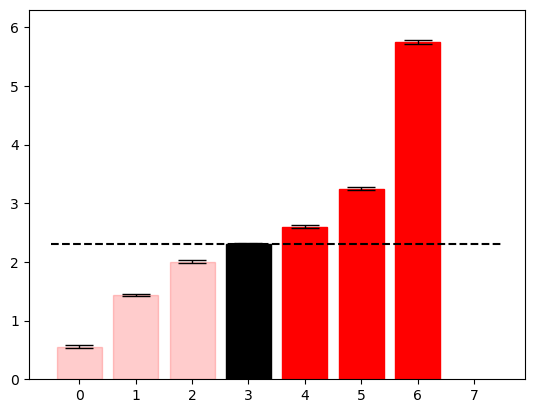

Sum of reward with intake / Number of intakes, altered interoception


In [201]:
error_bar_set = dict(lw = 1, capthick = 1, capsize = 10)

# Describe altered IC

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
#print(R_y_IC)
#print(R_e_IC)

bar_R_IC = ax.bar(left, R_y_IC, yerr = R_e_IC, error_kw=error_bar_set)
ax.hlines(Divided_Rewards[3], -0.5, len(left)+0.5, linestyle="dashed", color="k")

for i in range(7):
  if i != 3:
    bar_R_IC[i].set_color('red')
  else:
    bar_R_IC[i].set_color('black')

for i in range(3):
  bar_R_IC[i].set_alpha(0.2)

for i in range(3):
  bar_R_IC[i+4].set_alpha(1)

ax.hlines(6, 0, len(left), color='white')
plt.show()
print("Sum of reward with intake / Number of intakes, altered interoception")

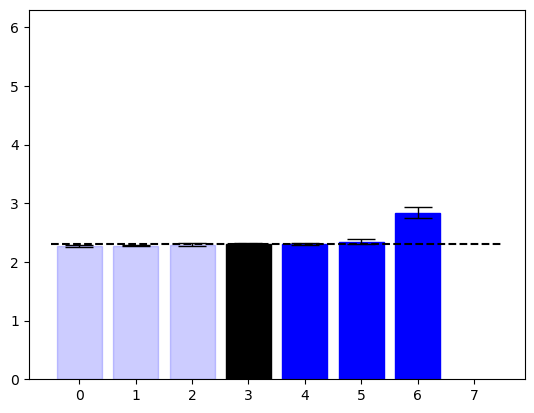

Sum of reward with intake / Number of intakes, altered beta


In [202]:
# Describe altered beta

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
bar_R_beta = ax.bar(left, R_y_beta, yerr = R_e_beta, error_kw=error_bar_set)
ax.hlines(Divided_Rewards[3], -0.5, len(left)+0.5, linestyle="dashed", color="k")



for i in range(7):
  if i != 3:
    bar_R_beta[i].set_color('blue')
  else:
    bar_R_beta[i].set_color('black')

for i in range(3):
  bar_R_beta[i].set_alpha(0.2)

for i in range(3):
  bar_R_beta[i+4].set_alpha(1)

ax.hlines(6, 0, len(left), color='white')
plt.show()
print("Sum of reward with intake / Number of intakes, altered beta")

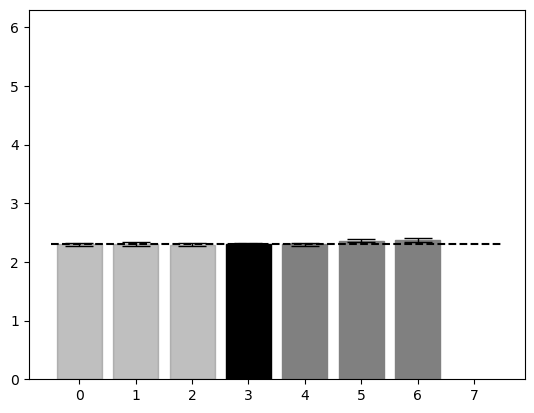

Sum of reward with intake / Number of intakes, altered gamma


In [203]:
# Describe altered gamma

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
bar_R_gamma = ax.bar(left, R_y_gamma, yerr = R_e_gamma, error_kw=error_bar_set)
ax.hlines(Divided_Rewards[3], -0.5, len(left)+0.5, linestyle="dashed", color="k")

for i in range(7):
  if i != 3:
    bar_R_gamma[i].set_color('gray')
  else:
    bar_R_gamma[i].set_color('black')

for i in range(3):
  bar_R_gamma[i].set_alpha(0.5)

for i in range(3):
  bar_R_gamma[i+4].set_alpha(1)

ax.hlines(6, 0, len(left), color='white')
plt.show()
print("Sum of reward with intake / Number of intakes, altered gamma")

In [194]:
# Levene's test: Sum of reward with intake / Number of intakes
# p<0.05 ---> not equal dev

Devided_Reward_Levene_p = []

Divided_Rewards_array = [Control_sum_RE, IC03_sum_RE, IC07_sum_RE, IC09_sum_RE, IC11_sum_RE, IC13_sum_RE, IC20_sum_RE,
                         beta10_sum_RE, beta5_sum_RE, beta1_sum_RE, beta05_sum_RE, beta03_sum_RE, beta01_sum_RE, 
                         gamma10_sum_RE, gamma099_sum_RE, gamma095_sum_RE, gamma07_sum_RE, gamma04_sum_RE, gamma01_sum_RE]

flag = True
ast = None
for i in range(1, 19):
  Devided_Reward_Levene_p.append(0)
  _, Devided_Reward_Levene_p[-1] = levene(Divided_Rewards_array[0], Divided_Rewards_array[i], center='mean')
  if Devided_Reward_Levene_p[-1] < 0.05:
    flag = False
  else:
    flag = True
  if ttest_ind(Divided_Rewards_array[0], Divided_Rewards_array[i], equal_var=flag).pvalue < 0.05:
    ast = "*"
  else:
    ast = "n.s."

  print(i, ttest_ind(Divided_Rewards_array[0], Divided_Rewards_array[i], equal_var=flag).pvalue, ast)

1 1.942076941681644e-79 *
2 3.219255719489635e-176 *
3 9.648080391463081e-143 *
4 5.115263662178517e-147 *
5 2.4508636157577123e-185 *
6 6.542224749737266e-228 *
7 4.6973326586741136e-05 *
8 0.00010227928790736749 *
9 0.16996601670550154 n.s.
10 0.16460998985584632 n.s.
11 5.705230567244694e-05 *
12 1.1746332152504042e-27 *
13 0.5506771503345981 n.s.
14 0.4150865523955153 n.s.
15 0.2600073390905797 n.s.
16 0.00030318366790988316 *
17 2.7962789117263155e-14 *
18 3.101230514654873e-22 *


In [195]:
# Figure: Sum of drive
left = np.array(list(range(7)))

Drives = []
Drives.append(IC03_sum_D.mean())
Drives.append(IC07_sum_D.mean())
Drives.append(IC09_sum_D.mean())

Drives.append(Control_sum_D.mean())

Drives.append(IC11_sum_D.mean())
Drives.append(IC13_sum_D.mean())
Drives.append(IC20_sum_D.mean())



Drives.append(beta10_sum_D.mean())
Drives.append(beta5_sum_D.mean())
Drives.append(beta1_sum_D.mean())

Drives.append(Control_sum_D.mean())

Drives.append(beta05_sum_D.mean())
Drives.append(beta03_sum_D.mean())
Drives.append(beta01_sum_D.mean())



Drives.append(gamma10_sum_D.mean())
Drives.append(gamma099_sum_D.mean())
Drives.append(gamma095_sum_D.mean())

Drives.append(Control_sum_D.mean())

Drives.append(gamma07_sum_D.mean())
Drives.append(gamma04_sum_D.mean())
Drives.append(gamma01_sum_D.mean())



Drives_array_IC = [IC09_sum_D, IC07_sum_D, IC03_sum_D, Control_sum_D, IC11_sum_D, IC13_sum_D, IC20_sum_D] 
Drives_array_beta = [beta10_sum_D, beta5_sum_D, beta1_sum_D, Control_sum_D, beta05_sum_D, beta03_sum_D, beta01_sum_D]
Drives_array_gamma = [gamma10_sum_D, gamma099_sum_D, gamma095_sum_D, Control_sum_D, gamma07_sum_D, gamma04_sum_D, gamma01_sum_D]


In [196]:
Drives_sd = []

Drives_sd.append(IC03_sum_D.std())
Drives_sd.append(IC07_sum_D.std())
Drives_sd.append(IC09_sum_D.std())

Drives_sd.append(Control_sum_D.std())

Drives_sd.append(IC11_sum_D.std())
Drives_sd.append(IC13_sum_D.std())
Drives_sd.append(IC20_sum_D.std())



Drives_sd.append(beta10_sum_D.std())
Drives_sd.append(beta5_sum_D.std())
Drives_sd.append(beta1_sum_D.std())

Drives_sd.append(Control_sum_D.std())

Drives_sd.append(beta05_sum_D.std())
Drives_sd.append(beta03_sum_D.std())
Drives_sd.append(beta01_sum_D.std())



Drives_sd.append(gamma10_sum_D.std())
Drives_sd.append(gamma099_sum_D.std())
Drives_sd.append(gamma095_sum_D.std())

Drives_sd.append(Control_sum_D.std())

Drives_sd.append(gamma07_sum_D.std())
Drives_sd.append(gamma04_sum_D.std())
Drives_sd.append(gamma01_sum_D.std())



Drive_y_IC = np.array(Drives[:7])
Drive_y_beta = np.array(Drives[7:14])
Drive_y_gamma = np.array(Drives[14:])

Drive_e_IC = np.array(Drives_sd[:7])
Drive_e_beta = np.array(Drives_sd[7:14])
Drive_e_gamma = np.array(Drives_sd[14:])

error_bar_set = dict(lw = 1, capthick = 1, capsize = 10)

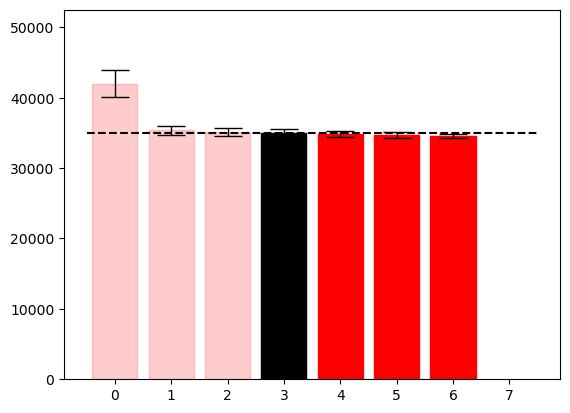

Sum of Drive, altered interoception


In [204]:
# Drive of altered ICの描画
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
bar_drive_IC = ax.bar(left, Drive_y_IC, yerr = Drive_e_IC, error_kw=error_bar_set)
ax.hlines(Drives[3], -0.5, len(left)+0.5, linestyle="dashed", color="k")

for i in range(7):
  if i != 3:
    bar_drive_IC[i].set_color('red')
  else:
    bar_drive_IC[i].set_color('black')

for i in range(3):
  bar_drive_IC[i].set_alpha(0.2)

for i in range(3):
  bar_drive_IC[i+4].set_alpha(1)

ax.hlines(50000, 0, len(left), color='white')
plt.show()
print("Sum of Drive, altered interoception")

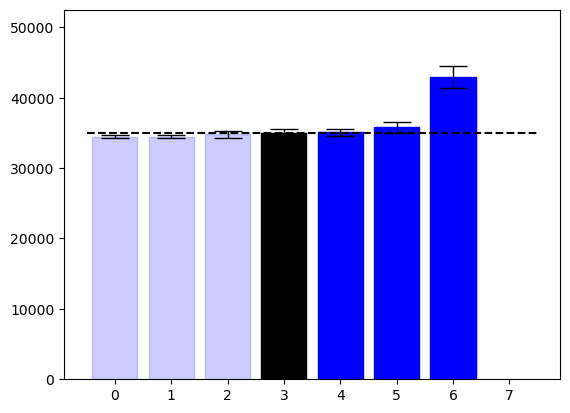

Sum of Drive, altered beta


In [205]:
# Drive of altered beta の描画
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
bar_drive_beta = ax.bar(left, Drive_y_beta, yerr = Drive_e_beta, error_kw=error_bar_set)
ax.hlines(Drives[3], -0.5, len(left)+0.5, linestyle="dashed", color="k")

for i in range(7):
  if i != 3:
    bar_drive_beta[i].set_color('blue')
  else:
    bar_drive_beta[i].set_color('black')

for i in range(3):
  bar_drive_beta[i].set_alpha(0.2)

for i in range(3):
  bar_drive_beta[i+4].set_alpha(1)

ax.hlines(50000, 0, len(left), color='white')
plt.show()
print("Sum of Drive, altered beta")

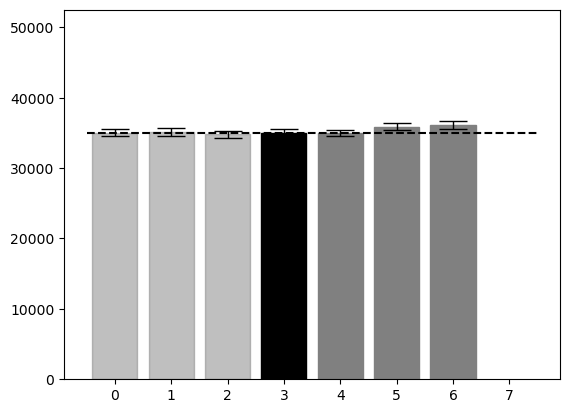

Sum of Drive, altered gamma


In [206]:
# Drive of altered gamma の描画
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
bar_drive_gamma = ax.bar(left, Drive_y_gamma, yerr = Drive_e_gamma, error_kw=error_bar_set)
ax.hlines(Drives[3], -0.5, len(left)+0.5, linestyle="dashed", color="k")

for i in range(7):
  if i != 3:
    bar_drive_gamma[i].set_color('gray')
  else:
    bar_drive_gamma[i].set_color('black')

for i in range(3):
  bar_drive_gamma[i].set_alpha(0.5)

for i in range(3):
  bar_drive_gamma[i+4].set_alpha(1)

ax.hlines(50000, 0, len(left), color='white')
plt.show()
print("Sum of Drive, altered gamma")

In [209]:
# Levene's test: Sum of drive
# p<0.05 ---> not equal dev

Drive_Levene_p = []

Drive_array = [Control_sum_D, IC03_sum_D, IC07_sum_D, IC09_sum_D, IC11_sum_D, IC13_sum_D, IC20_sum_D, 
               beta10_sum_D, beta5_sum_D, beta1_sum_D, beta05_sum_D, beta03_sum_D, beta01_sum_D,
               gamma10_sum_D, gamma099_sum_D, gamma095_sum_D, gamma07_sum_D, gamma04_sum_D, gamma01_sum_D]

flag = True
ast = None
for i in range(1, 19):
  Drive_Levene_p.append(0)
  _, Drive_Levene_p[-1] = levene(Drive_array[0], Drive_array[i], center='mean')
  if Drive_Levene_p[-1] < 0.05:
    flag = False
  else:
    flag = True
  if ttest_ind(Drive_array[0], Drive_array[i], equal_var=flag).pvalue < 0.05:
    ast = "*"
  else:
    ast = "n.s."

  print(i, ttest_ind(Drive_array[0], Drive_array[i], equal_var=flag).pvalue, ast)


1 1.3210087152618786e-26 *
2 0.001403759189645889 *
3 0.11944761650590976 n.s.
4 0.41741799348473996 n.s.
5 0.09586407538380047 n.s.
6 0.0035539750353615392 *
7 1.3397693466857426e-05 *
8 5.751135717986388e-05 *
9 0.2648294424565759 n.s.
10 0.15146163589237763 n.s.
11 1.6892085377606517e-06 *
12 1.6741380316221755e-34 *
13 0.3342652793770349 n.s.
14 0.22827957078890737 n.s.
15 0.2940639019335867 n.s.
16 0.7972807033839949 n.s.
17 1.0655276828982847e-10 *
18 4.810016303012288e-13 *


In [210]:
# mean of punishment in episode
Punish = []

Punish.append(mean(np.array(IC03_all_R) - np.array(IC03_sum_RE)))
Punish.append(mean(np.array(IC07_all_R) - np.array(IC07_sum_RE)))
Punish.append(mean(np.array(IC09_all_R) - np.array(IC09_sum_RE)))

Punish.append(mean(np.array(Control_all_R) - np.array(Control_sum_RE)))

Punish.append(mean(np.array(IC11_all_R) - np.array(IC11_sum_RE)))
Punish.append(mean(np.array(IC13_all_R) - np.array(IC13_sum_RE)))
Punish.append(mean(np.array(IC20_all_R) - np.array(IC20_sum_RE)))


Punish.append(mean(np.array(beta10_all_R) - np.array(beta10_sum_RE)))
Punish.append(mean(np.array(beta5_all_R) - np.array(beta5_sum_RE)))
Punish.append(mean(np.array(beta1_all_R) - np.array(beta1_sum_RE)))

Punish.append(mean(np.array(Control_all_R) - np.array(Control_sum_RE)))

Punish.append(mean(np.array(beta05_all_R) - np.array(beta05_sum_RE)))
Punish.append(mean(np.array(beta03_all_R) - np.array(beta03_sum_RE)))
Punish.append(mean(np.array(beta01_all_R) - np.array(beta01_sum_RE)))


Punish.append(mean(np.array(gamma10_all_R) - np.array(gamma10_sum_RE)))
Punish.append(mean(np.array(gamma099_all_R) - np.array(gamma099_sum_RE)))
Punish.append(mean(np.array(gamma095_all_R) - np.array(gamma095_sum_RE)))

Punish.append(mean(np.array(Control_all_R) - np.array(Control_sum_RE)))

Punish.append(mean(np.array(gamma07_all_R) - np.array(gamma07_sum_RE)))
Punish.append(mean(np.array(gamma04_all_R) - np.array(gamma04_sum_RE)))
Punish.append(mean(np.array(gamma01_all_R) - np.array(gamma01_sum_RE)))


Punish_array_IC = [np.array(IC03_all_R) - np.array(IC03_sum_RE), np.array(IC07_all_R) - np.array(IC07_sum_RE), np.array(IC09_all_R) - np.array(IC09_sum_RE),
                   np.array(Control_all_R) - np.array(Control_sum_RE), np.array(IC11_all_R) - np.array(IC11_sum_RE), np.array(IC13_all_R) - np.array(IC13_sum_RE),
                   np.array(IC20_all_R) - np.array(IC20_sum_RE)]
Punish_array_beta = [np.array(beta10_all_R) - np.array(beta10_sum_RE), np.array(beta5_all_R) - np.array(beta5_sum_RE), np.array(beta1_all_R) - np.array(beta1_sum_RE),
                     np.array(Control_all_R) - np.array(Control_sum_RE), np.array(beta05_all_R) - np.array(beta05_sum_RE), np.array(beta03_all_R) - np.array(beta03_sum_RE),
                     np.array(beta01_all_R) - np.array(beta01_sum_RE)]
Punish_array_gamma = [np.array(gamma10_all_R) - np.array(gamma10_sum_RE), np.array(gamma099_all_R) - np.array(gamma099_sum_RE), np.array(gamma095_all_R) - np.array(gamma095_sum_RE),
                      np.array(Control_all_R) - np.array(Control_sum_RE), np.array(gamma07_all_R) - np.array(gamma07_sum_RE), np.array(gamma04_all_R) - np.array(gamma04_sum_RE),
                      np.array(gamma01_all_R) - np.array(gamma01_sum_RE)]


In [211]:
# SD of punishment in episode

Punish_sd = []


Punish_sd.append(np.std(np.array(IC03_all_R) - np.array(IC03_sum_RE)))
Punish_sd.append(np.std(np.array(IC07_all_R) - np.array(IC07_sum_RE)))
Punish_sd.append(np.std(np.array(IC09_all_R) - np.array(IC09_sum_RE)))

Punish_sd.append(np.std(np.array(Control_all_R) - np.array(Control_sum_RE)))

Punish_sd.append(np.std(np.array(IC11_all_R) - np.array(IC11_sum_RE)))
Punish_sd.append(np.std(np.array(IC13_all_R) - np.array(IC13_sum_RE)))
Punish_sd.append(np.std(np.array(IC20_all_R) - np.array(IC20_sum_RE)))


Punish_sd.append(np.std(np.array(beta10_all_R) - np.array(beta10_sum_RE)))
Punish_sd.append(np.std(np.array(beta5_all_R) - np.array(beta5_sum_RE)))
Punish_sd.append(np.std(np.array(beta1_all_R) - np.array(beta1_sum_RE)))

Punish_sd.append(np.std(np.array(Control_all_R) - np.array(Control_sum_RE)))

Punish_sd.append(np.std(np.array(beta05_all_R) - np.array(beta05_sum_RE)))
Punish_sd.append(np.std(np.array(beta03_all_R) - np.array(beta03_sum_RE)))
Punish_sd.append(np.std(np.array(beta01_all_R) - np.array(beta01_sum_RE)))


Punish_sd.append(np.std(np.array(gamma10_all_R) - np.array(gamma10_sum_RE)))
Punish_sd.append(np.std(np.array(gamma099_all_R) - np.array(gamma099_sum_RE)))
Punish_sd.append(np.std(np.array(gamma095_all_R) - np.array(gamma095_sum_RE)))

Punish_sd.append(np.std(np.array(Control_all_R) - np.array(Control_sum_RE)))

Punish_sd.append(np.std(np.array(gamma07_all_R) - np.array(gamma07_sum_RE)))
Punish_sd.append(np.std(np.array(gamma04_all_R) - np.array(gamma04_sum_RE)))
Punish_sd.append(np.std(np.array(gamma01_all_R) - np.array(gamma01_sum_RE)))





Punish_y_IC = np.array(Punish[:7])
Punish_e_IC = np.array(Punish_sd[:7])

Punish_y_beta = np.array(Punish[7:14])
print(Punish_y_beta)
Punish_e_beta = np.array(Punish_sd[7:14])
print(Punish_e_beta)

Punish_y_gamma = np.array(Punish[14:])
Punish_e_gamma = np.array(Punish_sd[14:])


[  -1.54848418   -1.85818101   -4.02594927   -5.04051153   -6.38711748
  -12.25300845 -109.82604793]
[ 1.54848418  1.51719844  3.3963141   4.18481287  3.38947796  6.92180582
 14.43619443]


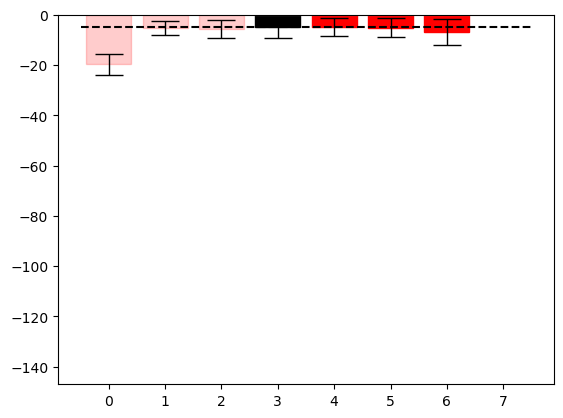

Punishment, altered interoception


In [214]:
# Punishment of altered ICの描画
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
bar_Punish_IC = ax.bar(left, Punish_y_IC, yerr = Punish_e_IC, error_kw=error_bar_set)
# ax.hlines(0.0, -0.5, len(left)+0.5, linestyle="dashed")
ax.hlines(Punish[3], -0.5, len(left)+0.5, linestyle="dashed", color="k")

for i in range(7):
  if i != 3:
    bar_Punish_IC[i].set_color('red')
  else:
    bar_Punish_IC[i].set_color('black')

for i in range(3):
  bar_Punish_IC[i].set_alpha(0.2)

for i in range(3):
  bar_Punish_IC[i+4].set_alpha(1)

ax.hlines(0, 0, len(left), color='white')
ax.hlines(-140, 0, len(left), color='white')
plt.show()
print("Punishment, altered interoception")

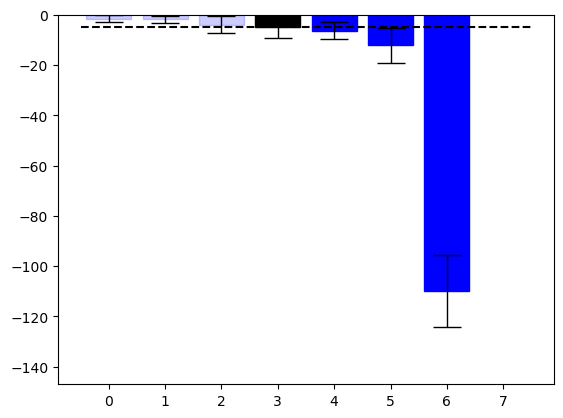

Punishment, altered beta


In [215]:
# Punishment of altered beta の描画
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
bar_Punish_beta = ax.bar(left, Punish_y_beta, yerr = Punish_e_beta, error_kw=error_bar_set)
ax.hlines(Punish[3], -0.5, len(left)+0.5, linestyle="dashed", color="k")

for i in range(7):
  if i != 3:
    bar_Punish_beta[i].set_color('blue')
  else:
    bar_Punish_beta[i].set_color('black')

for i in range(3):
  bar_Punish_beta[i].set_alpha(0.2)

for i in range(3):
  bar_Punish_beta[i+4].set_alpha(1)

ax.hlines(-140, 0, len(left), color='white')
plt.show()
print("Punishment, altered beta")

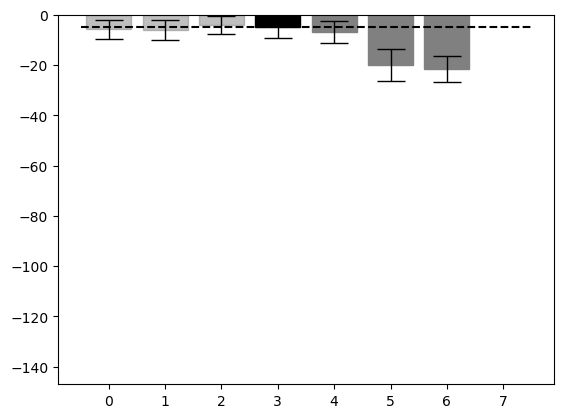

Punishment, altered gamma


In [216]:
# Punishment of altered gamma の描画
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
bar_Punish_gamma = ax.bar(left, Punish_y_gamma, yerr = Punish_e_gamma, error_kw=error_bar_set)
ax.hlines(Punish[3], -0.5, len(left)+0.5, linestyle="dashed", color="k")

for i in range(7):
  if i != 3:
    bar_Punish_gamma[i].set_color('gray')
  else:
    bar_Punish_gamma[i].set_color('black')

for i in range(3):
  bar_Punish_gamma[i].set_alpha(0.5)

for i in range(3):
  bar_Punish_gamma[i+4].set_alpha(1)

ax.hlines(-140, 0, len(left), color='white')
plt.show()
print("Punishment, altered gamma")

In [217]:
# Levene's test: punishment
# p<0.05 ---> not equal dev

Punish_Levene_p = []

Punish_array = np.r_[[np.array(Control_all_R) - np.array(Control_sum_RE)], 
                     [np.array(IC03_all_R) - np.array(IC03_sum_RE)],
                     [np.array(IC07_all_R) - np.array(IC07_sum_RE)],
                     [np.array(IC09_all_R) - np.array(IC09_sum_RE)],
                     [np.array(IC11_all_R) - np.array(IC11_sum_RE)],
                     [np.array(IC13_all_R) - np.array(IC13_sum_RE)],
                     [np.array(IC20_all_R) - np.array(IC20_sum_RE)],
                     [np.array(beta10_all_R) - np.array(beta10_sum_RE)],
                     [np.array(beta5_all_R) - np.array(beta5_sum_RE)],
                     [np.array(beta1_all_R) - np.array(beta1_sum_RE)],
                     [np.array(beta05_all_R) - np.array(beta05_sum_RE)],
                     [np.array(beta03_all_R) - np.array(beta03_sum_RE)],
                     [np.array(beta01_all_R) - np.array(beta01_sum_RE)],
                     [np.array(gamma10_all_R) - np.array(gamma10_sum_RE)],
                     [np.array(gamma099_all_R) - np.array(gamma099_sum_RE)],
                     [np.array(gamma095_all_R) - np.array(gamma095_sum_RE)],
                     [np.array(gamma07_all_R) - np.array(gamma07_sum_RE)],
                     [np.array(gamma04_all_R) - np.array(gamma04_sum_RE)],
                     [np.array(gamma01_all_R) - np.array(gamma01_sum_RE)]]
                     
print(len(Punish_array))


flag = True
ast = None
for i in range(1, 19):
  Punish_Levene_p.append(0)
  _, Punish_Levene_p[-1] = levene(Punish_array[0], Punish_array[i], center='mean')
  if Punish_Levene_p[-1] < 0.05:
    flag = False
  else:
    flag = True
  if ttest_ind(Punish_array[0], Punish_array[i], equal_var=flag).pvalue < 0.05:
    ast = "*"
  else:
    ast = "n.s."

  print(i, ttest_ind(Punish_array[0], Punish_array[i], equal_var=flag).pvalue, ast)


19
1 9.801075930210002e-26 *
2 0.7600685525294121 n.s.
3 0.4774305256621143 n.s.
4 0.9016576624079926 n.s.
5 0.8916283848890181 n.s.
6 0.101512922570644 n.s.
7 1.1168690495642747e-05 *
8 4.704217925517242e-05 *
9 0.24333471922071148 n.s.
10 0.12243498312745359 n.s.
11 5.424758028406185e-07 *
12 9.717349501570815e-39 *
13 0.3462903445532579 n.s.
14 0.24194364297211834 n.s.
15 0.2906593934527338 n.s.
16 0.06206413980644457 n.s.
17 6.109298047423706e-19 *
18 6.309366595348439e-26 *


In [218]:
from pickle import TRUE
import pandas as pd
import scipy.stats as st

Intake_Levene_p = []

Intake_array = [Control_sum_intake, IC03_sum_intake, IC07_sum_intake, IC09_sum_intake, IC11_sum_intake, IC13_sum_intake, IC20_sum_intake, 
               beta10_sum_intake, beta5_sum_intake, beta1_sum_intake, beta05_sum_intake, beta03_sum_intake, beta01_sum_intake,
               gamma10_sum_intake, gamma099_sum_intake, gamma095_sum_intake, gamma07_sum_intake, gamma04_sum_intake, gamma01_sum_intake]

flag = True
ast = None
for i in range(1, 19):
  Intake_Levene_p.append(0)
  _, Intake_Levene_p[-1] = st.levene(Intake_array[0], Intake_array[i], center='mean')
  if Intake_Levene_p[-1] < 0.05:
    flag = False
  else:
    flag = True
  if st.ttest_ind(Intake_array[0], Intake_array[i], equal_var=flag).pvalue < 0.05:
    ast = "*"
  else:
    ast = "n.s."

  print(i, st.ttest_ind(Intake_array[0], Intake_array[i], equal_var=flag).pvalue, ast)

1 1.092172859655755e-27 *
2 0.0008087600786602695 *
3 0.11813069773216692 n.s.
4 0.40565764863205767 n.s.
5 0.08761485555848204 n.s.
6 0.003062221123862011 *
7 1.2021586806719334e-05 *
8 5.036964523445797e-05 *
9 0.24828138792880883 n.s.
10 0.13148253076156297 n.s.
11 6.369378142350019e-07 *
12 1.4305581116538066e-36 *
13 0.34551354068101614 n.s.
14 0.24006117502258012 n.s.
15 0.29086680741190346 n.s.
16 0.10355415542291202 n.s.
17 4.1070149881192776e-19 *
18 3.4805390099378916e-24 *
